In [223]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv1D, Dropout, Dense, Embedding, Flatten, Reshape, Multiply, Lambda, UpSampling1D, MaxPooling1D
from keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

<h1>Traitement des données</h1>

In [224]:
# chargement des deux tables
real_news = pd.read_csv("./dataset1/True.csv")
fake_news = pd.read_csv("./dataset1/Fake.csv")

In [225]:
# vrai = 1, faux = 0
real_news["label"] = 1
fake_news["label"] = 0

In [226]:
# création du dataset complet
dataframe = pd.concat([real_news, fake_news])
dataframe.sample(10)

,title,text,subject,date,label
7338,Watch This CBS Host Utterly DEMOLISH Ted Cruz...,Ted Cruz has said many stupid things during hi...,News,"March 23, 2016",0
12335,China angered as U.S. considers navy visits to...,BEIJING/TAIPEI (Reuters) - China accused the U...,worldnews,"December 14, 2017",1
7483,The KKK Leader The Media Said ‘Endorsed’ Hill...,Fox News and other right-wing outlets are quiv...,News,"March 15, 2016",0
13886,Fire in hotel on Georgia's Black Sea coast kil...,TBILISI (Reuters) - A fire in a hotel in Georg...,worldnews,"November 25, 2017",1
15062,TREY GOWDY: “Look at the facts”…”Ambassador St...,Gowdy hammers it with those who say Benghazi w...,politics,"Oct 19, 2015",0
13255,OOPS! New App Allows Users To Remain ANONYMOUS...,Funny what happens when liberals aren t able t...,politics,"Aug 13, 2016",0
11798,"After U.S. veto, U.N. General Assembly to meet...",UNITED NATIONS (Reuters) - The 193-member Unit...,worldnews,"December 19, 2017",1
8923,Trump's opposition to trade deals fuels intern...,WASHINGTON (Reuters) - Presidential candidate ...,politicsNews,"June 29, 2016",1
19704,ABSOLUTELY STUNNING VIDEO Shows How One Hacker...,This video shows the frightening ease with whi...,left-news,"Oct 31, 2016",0
17309,Syrian refugees should return to calmer areas:...,BEIRUT (Reuters) - Lebanon can no longer handl...,worldnews,"October 16, 2017",1


In [227]:
print(f"Nombre de références : {dataframe.title.count()}")
print(f"Nombre de fake news : {fake_news.title.count()}")
print(f"Nombre de vraies news : {real_news.title.count()}")

Nombre de références : 44898
Nombre de fake news : 23481
Nombre de vraies news : 21417


In [228]:
# ici on ne s'intéresse qu'au titre et au label
del dataframe["text"]
del dataframe["subject"]
del dataframe["date"]

In [229]:
dataframe.sample(10)

,title,label
3343,Justice Department halts settlements funding o...,1
16996,UNREAL! Michelle Obama Gets $70 Million For Pr...,0
17893,Moscow gives green light to CNN International ...,1
13494,"Pope lands in Bangladesh, to meet Rohingya gro...",1
19630,26 BASEMENT DWELLERS ARRESTED In Oregon Riots…...,0
8572,Clinton says Russian intelligence services hac...,1
9251,Bombshell! Rep. Jim Jordan: FBI Paid for Fake ...,0
19778,DEMOCRAT THUGS VANDALIZE REPUBLICAN Offices Ac...,0
19800,"UK government, including Johnson, united behin...",1
15338,SCRUBBED CLEAN? HILLARY CLINTON TO FINALLY TUR...,0


In [230]:
# nettoyage des données (ponctuations)

#stopWords = set(stopwords.words("english"))

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–",".","&"}
    res = str(text)
    if res != None:
        for elm in forbidden:
            res = res.replace(elm, "")
    if len(res.split()) >= 30:
        res = " ".join(res.split()[0:30])
    if res != None:
        for elm in forbidden:
            res = res.replace("  ", " ")
    return res

dataframe["title"] = dataframe["title"].apply(cleanText)

In [231]:
dataframe["title"]

0        As US budget fight looms Republicans flip thei...
1        US military to accept transgender recruits on ...
2        Senior US Republican senator Let Mr Mueller do...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge much more...
                               ...                        
23476    McPain John McCain Furious That Iran Treated U...
23477    JUSTICE Yahoo Settles Email Privacy Classactio...
23478    Sunnistan US and Allied Safe Zone Plan to Take...
23479    How to Blow $700 Million Al Jazeera America Fi...
23480    10 US Navy Sailors Held by Iranian Military Si...
Name: title, Length: 44898, dtype: object

In [232]:
# on sépare les données en données d'entraînement et données de test (80% et 20%)
x_train, x_test, y_train, y_test = train_test_split(dataframe["title"], dataframe["label"], test_size=0.10, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 40408
Données de test : 4490


In [233]:
max_features = 10000 # taille max du vocab
maxlen = 15 # taille max de séquence

In [234]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(dataframe["title"])

In [235]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)
y_train = np.array(y_train)

In [236]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)

In [237]:
batch_size = 256
nb_epochs = 20
embedded_dim = 100
latent_dim = 100
kernel_size = 10

In [238]:
def generate_latent_points(latent_dim, nbpoints):
    return np.random.uniform(0, 1, size=[nbpoints, latent_dim])

def getLatentSamples(latent_dim, n):
    labels = np.zeros(shape=n)
    samples = generate_latent_points(latent_dim, n)
    
    return samples, labels

def getFakeSamples(generator, latent_dim, n):
    labels = np.ones(shape=n)
    
    latent_points = generate_latent_points(latent_dim, n)
    samples = generator.predict(latent_points)
    
    return samples, labels

def getRealSamples(X, Y, n):
    random_indices = np.random.randint(0, X.shape[0], n)

    samples = X[random_indices]
    labels = Y[random_indices]
    
    return samples, labels

def generateFakeNews(model, n):
    few_points = generate_latent_points(latent_dim, n)
    predictions = generator.predict(few_points)
    fake_news = tokenizer.sequences_to_texts(np.round(predictions))
    
    return fake_news

In [239]:
def create_generator(dim):
    
    input_layer = Input(shape=[dim])
    
    x = Dense(maxlen, input_shape=[dim])(input_layer)
    
    x = Reshape((maxlen, 1))(x)
    x = Conv1D(128, kernel_size, padding="same")(x)
    x = UpSampling1D()(x)
    x = Conv1D(64, kernel_size, padding="same")(x)
    x = UpSampling1D()(x)
    x = Conv1D(32, kernel_size, padding="same")(x)
    
    x = Flatten()(x)
    x = Dense(maxlen, activation="sigmoid")(x)
    
    output_layer = Lambda(lambda x: x * float(max_features))(x)

    model = Model(input_layer, output_layer)
    model.compile(loss="mse", optimizer=Adam(lr=0.0002, beta_1=.5))
    
    model.summary()
    
    return model

def create_discriminator():

    input_layer = Input(shape=[maxlen])
    
    #x = Embedding(max_features, output_dim=embedded_dim, input_length=maxlen, trainable=True, input_shape=[maxlen])(input_layer)
    x = Dense(embedded_dim * maxlen)(input_layer)
    x = Reshape((maxlen, embedded_dim))(x)
    x = Conv1D(128, kernel_size, padding="same")(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, kernel_size, padding="same")(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.1)(x)
    x = Conv1D(32, kernel_size, padding="same")(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    
    output_layer = Dense(1, activation="softmax")(x)
    
    model = Model(input_layer, output_layer)
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002, beta_1=.5))
    model.summary()
    
    return model

def create_gan(generator, discriminator, latent_dim):
    
    input_layer = Input(shape=[latent_dim])
    
    x = generator(input_layer)
    
    output_layer = discriminator(x)
    
    model = Model(input_layer, output_layer)

    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002, beta_1=.5))
    model.summary()
    
    return model

In [240]:
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan = create_gan(generator, discriminator, latent_dim)

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 15)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1500)              24000     
_________________________________________________________________
reshape_21 (Reshape)         (None, 15, 100)           0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 15, 128)           128128    
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 7, 64)             81984     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 3, 64)             0  

In [241]:
def train(generator_model, discriminator_model, gan_model, nb_epochs, batch_size):
    discriminator_losses = []
    
    generator_losses = []
    
    for i in range(nb_epochs):

        x_fake, y_fake = getFakeSamples(generator_model, latent_dim, batch_size)
        x_real, y_real = getRealSamples(x_train, y_train, batch_size)
        
        discriminator_model.trainable = True

        loss1 = discriminator_model.train_on_batch(x_real, y_real)
        loss2 = discriminator_model.train_on_batch(x_fake, y_fake)
        loss3 = (loss1 + loss2) / 2
        
        discriminator_model.trainable = False
        
        x_gan, y_gan = getLatentSamples(latent_dim, batch_size)        
        
        loss_gan = gan_model.train_on_batch(x_gan, y_gan)

        discriminator_losses.append(loss3)
        
        generator_losses.append(loss_gan)
        
        print(f"Epoch {i}  ;  Discriminator loss : {loss3}   ;    Generator loss : {loss_gan}", end="\r")
        if i % 100 == 0:
            print("\n")
            print(generateFakeNews(generator_model, 1))
        
    return discriminator_losses, generator_losses

In [242]:
DL, GL = train(generator, discriminator, gan, 50000, batch_size)

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0  ;  Discriminator loss : 3.773414373397827   ;    Generator loss : 15.333237648010254

['joseph prestigious matter” wide ll suggested murdering packed spark skin wwii watson ginsburg “very engagement']
Epoch 100  ;  Discriminator loss : 4.252577781677246   ;    Generator loss : 15.333237648010254

['oppression importance bodyguard wears losers exchanges accountable cavuto shakeup insurgents erupt swap priorities rncs rncs']
Epoch 200  ;  Discriminator loss : 4.252577781677246   ;    Generator loss : 15.3332376480102544

['lawrence capture cftc spreads advocate shipping 93 “let ivory gohmert stood intervention trips tarmac designed']
Epoch 300  ;  Discriminator loss : 4.132786750793457   ;    Generator loss : 15.3332376480102544

['cautious liz “oh clarify lewinsky imposes helton chased builds meaning kurz yearend allegiance baiting accountable']
Epoch 400  ;  Discriminator loss : 3.893205404281616   ;    Generator loss : 15.3332376480102544

['hated profits preacher spreads poc

Epoch 3700  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

['returned bernies barzani specific clerk increased skin framework advisors tree happening akbar” feinstein windows consensus']
Epoch 3800  ;  Discriminator loss : 4.042943477630615   ;    Generator loss : 15.3332376480102544

['differences saving fines legislature boos gear raceobsessed melt wealth abandoning miami hiroshima walker adele upbeat']
Epoch 3900  ;  Discriminator loss : 4.102839469909668   ;    Generator loss : 15.3332376480102544

['howard hatefilled accomplishments whiny pool strategic 42 kissing restraint hedge marks morocco vehicles turnout revealing']
Epoch 4000  ;  Discriminator loss : 4.132787227630615   ;    Generator loss : 15.3332376480102544

['deutsche ha tanks genocide heckler hitting skin lone nieto instagram sitting yell feinstein revenue h']
Epoch 4100  ;  Discriminator loss : 4.492159843444824   ;    Generator loss : 15.3332376480102544

['phones academy post

Epoch 7400  ;  Discriminator loss : 4.042943954467773   ;    Generator loss : 15.3332376480102544

['asst ammon libertarian petty africanamerican guidelines atlanta silicon wears irrelevant monitor standards uns monitor sponsor']
Epoch 7500  ;  Discriminator loss : 3.7135188579559326   ;    Generator loss : 15.333237648010254

['unexpected defamation cares choices dictators miracle gear example capable rubios mladic sentencing dealt loom murdering']
Epoch 7600  ;  Discriminator loss : 4.402316570281982   ;    Generator loss : 15.3332376480102544

['negotiate talked shameful affected heckler tested rein lockdown faking expensive demanded resigning philadelphia kellys women”']
Epoch 7700  ;  Discriminator loss : 3.893204927444458   ;    Generator loss : 15.3332376480102544

['deploys moms suspicions spray peters pathetically imaginable expel sheriffs bolster bravo clearly possibly 150 redux']
Epoch 7800  ;  Discriminator loss : 4.252578258514404   ;    Generator loss : 15.333237648010254

Epoch 11100  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

['offshore charts defensive mali duty jobless unfair scotlands sexism disgraceful setting mobile rex express “russia']
Epoch 11200  ;  Discriminator loss : 3.983048439025879   ;    Generator loss : 15.3332376480102544

['possibly spill individual restored silver belt prospects qualify rabid flames optimistic filibuster dealt charities murdering']
Epoch 11300  ;  Discriminator loss : 4.19268274307251   ;    Generator loss : 15.33323764801025454

['departure territory ships catches accomplishments bosnian passionate doom counts christies heavy kellys obliterates tanzania austria']
Epoch 11400  ;  Discriminator loss : 4.342421054840088   ;    Generator loss : 15.3332376480102544

['steins lincoln prevented delivered havent hater qualified testifying tops capitalism aclu suffers romania sour rocker']
Epoch 11500  ;  Discriminator loss : 3.86325740814209   ;    Generator loss : 15.33323764801

Epoch 14800  ;  Discriminator loss : 4.072891712188721   ;    Generator loss : 15.3332376480102544

['wildlife “comedian” pornography fell weighing schulz sponsors “every management readers stalled dissidents hook schedule 89']
Epoch 14900  ;  Discriminator loss : 4.102839469909668   ;    Generator loss : 15.3332376480102544

['sanaa filibuster loom genius reserves nh shaming 99 apec xl kingmaker though traitor sprayed h']
Epoch 15000  ;  Discriminator loss : 4.372368812561035   ;    Generator loss : 15.3332376480102544

['hate” despicable weinsteins wealth legendary appointee patriotism cemetery viciously requirements speech” liberia ramadan ali swift']
Epoch 15100  ;  Discriminator loss : 3.8333096504211426   ;    Generator loss : 15.333237648010254

['carsons auto decade disgust cleared romneys returned kissing correctness richard blasio personnel grills wiretapped tyranny']
Epoch 15200  ;  Discriminator loss : 3.7135190963745117   ;    Generator loss : 15.333237648010254

['boosts 

Epoch 18500  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

['till shouting irrelevant “our rein uncomfortable stations perez lock uzbek violating richard legislature donates jihadists']
Epoch 18600  ;  Discriminator loss : 4.132786750793457   ;    Generator loss : 15.3332376480102544

['connections deploy imports tops gen lectures shockingly burundi ivory covered youve prior gunmen murderer kiev']
Epoch 18700  ;  Discriminator loss : 3.8632571697235107   ;    Generator loss : 15.333237648010254

['rinos auto texts allen mull liars lungs declassified yard shredded philadelphia athletes upon stays poisoned']
Epoch 18800  ;  Discriminator loss : 4.042943954467773   ;    Generator loss : 15.3332376480102544

['antitrust pic charts nonsense swinging finland cummings framework credentials written “our seizure jrs bailout craft']
Epoch 18900  ;  Discriminator loss : 4.222630023956299   ;    Generator loss : 15.3332376480102544

['athletes singing resci

Epoch 22200  ;  Discriminator loss : 3.653623104095459   ;    Generator loss : 15.3332376480102544

['imminent boos portugal forgotten tables stumbles rescinds loans internal expm genocide melanias ugandan territory microsoft']
Epoch 22300  ;  Discriminator loss : 4.102839469909668   ;    Generator loss : 15.3332376480102544

['disregard barcelona rooms transportation findings hesher misses passing uproar raceobsessed opposed paint offshore deploy cyprus']
Epoch 22400  ;  Discriminator loss : 4.072891712188721   ;    Generator loss : 15.3332376480102544

['tweetstorm jobless winter accent charts alex responses ssed affected damages label seizes survives rumors protectionism']
Epoch 22500  ;  Discriminator loss : 4.102839469909668   ;    Generator loss : 15.3332376480102544

['contractor 43 panicking picked typhoon cohost isolated 67 admissions rt thailands unexpected romanian ivankas tickets']
Epoch 22600  ;  Discriminator loss : 3.8333096504211426   ;    Generator loss : 15.3332376480

Epoch 25900  ;  Discriminator loss : 4.252577781677246   ;    Generator loss : 15.3332376480102544

['bullies bulgaria adding extremists 38 cliven constituents properties chamber grow transport jihadi country” consumers castros']
Epoch 26000  ;  Discriminator loss : 4.102839469909668   ;    Generator loss : 15.3332376480102544

['hardline limbo positions deblasio trends slamming imagesvideo ma suffer madness respects “most frontrunner pentagons misses']
Epoch 26100  ;  Discriminator loss : 3.773414134979248   ;    Generator loss : 15.3332376480102544

['allegation regions abuses stores turnout braces ships now” motion cohost lobbyist miracle exploding medal palace']
Epoch 26200  ;  Discriminator loss : 4.012996196746826   ;    Generator loss : 15.3332376480102544

['wonderful clerk hungarian motorcade slaves rouge channels countrys euros “very crony deploy pic jumps formally']
Epoch 26300  ;  Discriminator loss : 4.19268274307251   ;    Generator loss : 15.33323764801025444

['division

Epoch 29600  ;  Discriminator loss : 3.9531006813049316   ;    Generator loss : 15.333237648010254

['atlanta bed quarter frightening shove conversations sour lowest nominations cftc learned tillersons bashed sara bosnian']
Epoch 29700  ;  Discriminator loss : 3.8333096504211426   ;    Generator loss : 15.333237648010254

['fugitive chose awful kurz jab bragged rid pressures correctness refers t” pilot allegiance graders jihadists']
Epoch 29800  ;  Discriminator loss : 3.983048439025879   ;    Generator loss : 15.3332376480102544

['libertarian tvs tanzania discredit preacher exchanges figures stake couples atlanta cutting sentencing recuse bragged abusive']
Epoch 29900  ;  Discriminator loss : 4.042943954467773   ;    Generator loss : 15.3332376480102544

['melanias asiapacific rift morgan rncs tanzania rein kenyans allen midler nationalists geraldo pen meaning instagram']
Epoch 30000  ;  Discriminator loss : 3.5937278270721436   ;    Generator loss : 15.333237648010254

['alabamas to

Epoch 33300  ;  Discriminator loss : 4.0728912353515625   ;    Generator loss : 15.333237648010254

['defamation sticking africans delegation location silver channels ankara joining chose joining reached pelosis nuke preacher']
Epoch 33400  ;  Discriminator loss : 3.773414134979248   ;    Generator loss : 15.3332376480102544

['desire “dirty obtain royal eliminate havent 41 twothirds talked prohillary pinera akbar” nut sudans rubios']
Epoch 33500  ;  Discriminator loss : 4.162734508514404   ;    Generator loss : 15.3332376480102544

['richard imaginable altleft shakes ss continued struck universities pr vietnamese separate rescinds season isolated violates']
Epoch 33600  ;  Discriminator loss : 3.923152446746826   ;    Generator loss : 15.3332376480102544

['degrasse appointee blitzer guinea qualified commentator transparency michele fallen closure sabotage timing upon poster stories']
Epoch 33700  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

[

Epoch 37000  ;  Discriminator loss : 3.8033618927001953   ;    Generator loss : 15.333237648010254

['responses finish imaginable scene atheist 92 strategic denying band atheists wives negotiate rex 100k suspicions']
Epoch 37100  ;  Discriminator loss : 4.132786750793457   ;    Generator loss : 15.3332376480102544

['charities responses increased reaching ll requirements cooperating yorks mp effective slapped nixon longterm loom seized']
Epoch 37200  ;  Discriminator loss : 4.0728912353515625   ;    Generator loss : 15.333237648010254

['legalize refers cards pyongyang egg earned toddler scammed disgust grid staged hungarys renewal troubled cfpb']
Epoch 37300  ;  Discriminator loss : 3.4439892768859863   ;    Generator loss : 15.333237648010254

['hungarys nod sentencing praised alex turnout kiev craft stays elementary encouraging addresses nye revolt positions']
Epoch 37400  ;  Discriminator loss : 4.072891712188721   ;    Generator loss : 15.3332376480102544

['switch steins depot bl

Epoch 40700  ;  Discriminator loss : 3.5038845539093018   ;    Generator loss : 15.333237648010254

['trashed spill imports scheduled patriotism cure loony communication deserve corps crack torched poison allegation nickname']
Epoch 40800  ;  Discriminator loss : 3.7135188579559326   ;    Generator loss : 15.333237648010254

['transfer gunmen 20000 tshirts pose gillibrand slaves koike 100000 expm rex angeles reagans monitor tune']
Epoch 40900  ;  Discriminator loss : 3.9531004428863525   ;    Generator loss : 15.333237648010254

['antisemitism wishes slips towns statehouse driven jab hats abused shaming elites 44 survive tweetstorm goodbye']
Epoch 41000  ;  Discriminator loss : 4.6418986320495605   ;    Generator loss : 15.333237648010254

['preelection constituents shutting fidel tens ricans antigovernment broadcast crack refers bahrain illness killers grilled schedule']
Epoch 41100  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

['walls kerrys 

Epoch 44400  ;  Discriminator loss : 4.342421054840088   ;    Generator loss : 15.3332376480102544

['lincoln expensive disregard lobbyist trailer 41 quarter sacks remind rift medias reply enforce shelter determined']
Epoch 44500  ;  Discriminator loss : 3.893205165863037   ;    Generator loss : 15.3332376480102544

['uzbek heats raceobsessed saint ssed berlusconi schulz directors correctness tyranny werent sara 100000 vietnamese pruitt']
Epoch 44600  ;  Discriminator loss : 4.162734508514404   ;    Generator loss : 15.3332376480102544

['graders dramatic tanks wide kicking agitator natural engagement penalty tvs troop pbs valley stir sweet']
Epoch 44700  ;  Discriminator loss : 4.072891712188721   ;    Generator loss : 15.3332376480102544

['connections charts defeated override rein thomas rerun meat manchester havent supported deploys pena addresses hawk']
Epoch 44800  ;  Discriminator loss : 4.342421054840088   ;    Generator loss : 15.3332376480102544

['joseph territory globe frig

Epoch 48100  ;  Discriminator loss : 3.773414134979248   ;    Generator loss : 15.3332376480102544

['jenner random hardline celebrations atheist charities basis mediate dirt filibuster broad capture allen liz egg']
Epoch 48200  ;  Discriminator loss : 3.773414134979248   ;    Generator loss : 15.3332376480102544

['bundys gunfire hater pee f35 deal” jumps keen renewed aka frontrunner poster ivory ego conversations']
Epoch 48300  ;  Discriminator loss : 4.10283899307251   ;    Generator loss : 15.33323764801025444

['bundys moms funneled macri denmark winter ed dumping familys statehouse choices “america pretending grow fields']
Epoch 48400  ;  Discriminator loss : 4.042943954467773   ;    Generator loss : 15.3332376480102544

['bidens defamation czar couples tree nkorea torn rethink steals mugabes series liberia medicare imminent preserve']
Epoch 48500  ;  Discriminator loss : 4.192682266235352   ;    Generator loss : 15.3332376480102544

['readies defamation succession rowe confront 

In [243]:
few_points = generate_latent_points(latent_dim, 10)
predictions = generator.predict(few_points)
#print(predictions)
print(tokenizer.sequences_to_texts(np.round(predictions)))

['classy giants closure couric physical 2005 fugitive representing renews irrelevant supported readers bump ego blitzer', 'police” jenner banner couric trailer wages 42 government” fines “put divisions deploys offshore ovation increased', 'chose charities “america pedophile skin jumps britons briefly testing protectionism easier oversee motorcade mandalay rants', 'abuses differences undermining fines tokyo nh nominated standard trumpsupporting “very transcript responses woods raceobsessed purchase', 'hands” globe parks couric kiev struck insurgents solid frightening schultz such cares prospect reply microphone', 'stages credits imagesvideo yearend tanzania mormon atheists confession route matter” prolife tribal montana farc pornography', 'significant bolster accountable scores pentagons peters lavoy gillibrand vehicles havent tips ovation reps soft mormon', 'familys “climate beer antiimmigrant abandoning insiders todays panicking gunmen activities 100000 recovery lock tanks struck', 'g

In [244]:
# art plastique du turfu featuring le poto matplotlib
from matplotlib import pyplot as plt

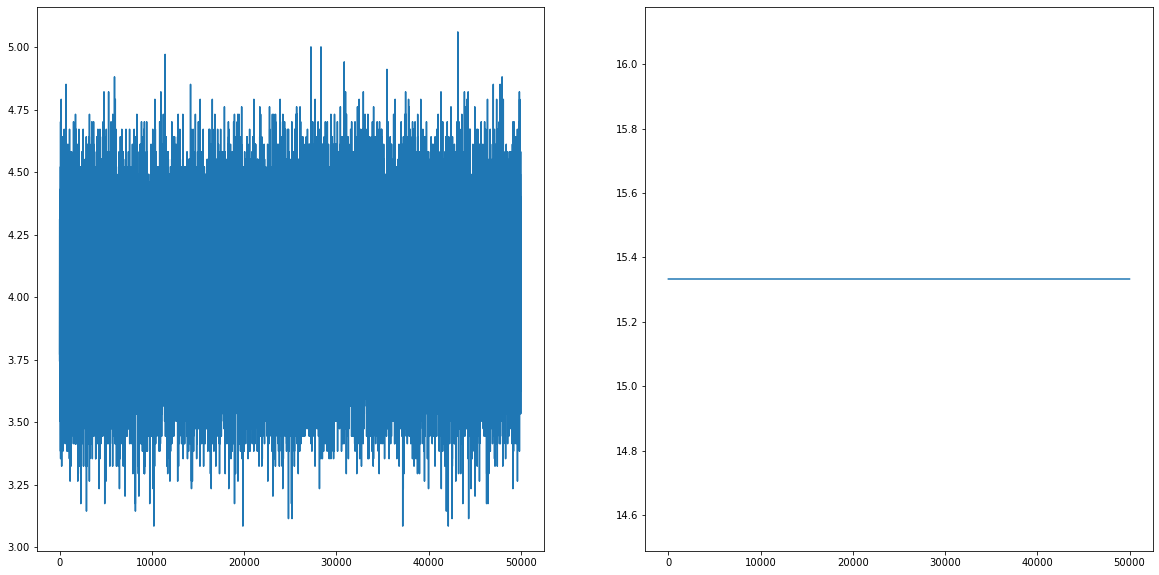

In [245]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(20,10)

ax[0].plot(DL)

ax[1].plot(GL)

plt.show()

In [246]:
to_predict = dataframe.sample(5)

In [247]:
X_test = to_predict["title"]
X_test

13949    WHOA West Virginia Coal Miners Just Made Power...
18355    VIDEO SHOWS Stunning Damage To Streets Of Hist...
16241    Top Mexico university blames deadly bridge col...
22296                Gerald Celente Top 10 Trends for 2017
5946     Two Florida ports cancel plans to ink pacts wi...
Name: title, dtype: object

In [248]:
Y_test = to_predict["label"]
Y_test

13949    0
18355    0
16241    1
22296    0
5946     1
Name: label, dtype: int64

In [249]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_test[0]

array([1176, 3391,   34,  343,  901,    4,    1,  131, 2085,   27,   14,
         28,  895,  233,   33])

In [250]:
model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
X_test

In [ ]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")
tokenizerJSON = tokenizer.to_json()

with open("gan_tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizerJSON, ensure_ascii=False))